In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch
import torch.nn as nn

class ShallowCNN(nn.Module):
    def __init__(self):
        super(ShallowCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)  # Add dropout layer with 50% probability

        # Dynamically compute the flattened size
        dummy_input = torch.zeros(1, 3, 640, 640)
        dummy_output = self._forward_conv(dummy_input)
        flattened_size = dummy_output.view(-1).size(0)

        self.fc1 = nn.Linear(flattened_size, 300)
        self.fc2 = nn.Linear(300, 2)

    def _forward_conv(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # Conv1 + ReLU + MaxPooling
        x = self.dropout(x)  # Apply dropout after pooling
        x = self.pool(self.relu(self.conv2(x)))  # Conv2 + ReLU + MaxPooling
        x = self.dropout(x)  # Apply dropout after pooling
        return x

    def forward(self, x):
        x = self._forward_conv(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.relu(self.fc1(x))  # Fully Connected Layer 1 + ReLU
        x = self.dropout(x)  # Apply dropout after FC1
        x = self.fc2(x)  # Fully Connected Layer 2 (Output Layer)
        return x

Starting Fold 1/3
Early stopping at epoch 24
Fold 1 - Train Loss: 0.3472, Val Loss: 0.5118, Train Acc: 0.8514, Val Acc: 0.7413
Precision: 0.8111, Recall: 0.7477, F1 Score: 0.7332
Starting Fold 2/3
Early stopping at epoch 13
Fold 2 - Train Loss: 0.4578, Val Loss: 0.5369, Train Acc: 0.7859, Val Acc: 0.7206
Precision: 0.7931, Recall: 0.7477, F1 Score: 0.7350
Starting Fold 3/3
Early stopping at epoch 13
Fold 3 - Train Loss: 0.4896, Val Loss: 0.5823, Train Acc: 0.7603, Val Acc: 0.6873
Precision: 0.7035, Recall: 0.6479, F1 Score: 0.6300


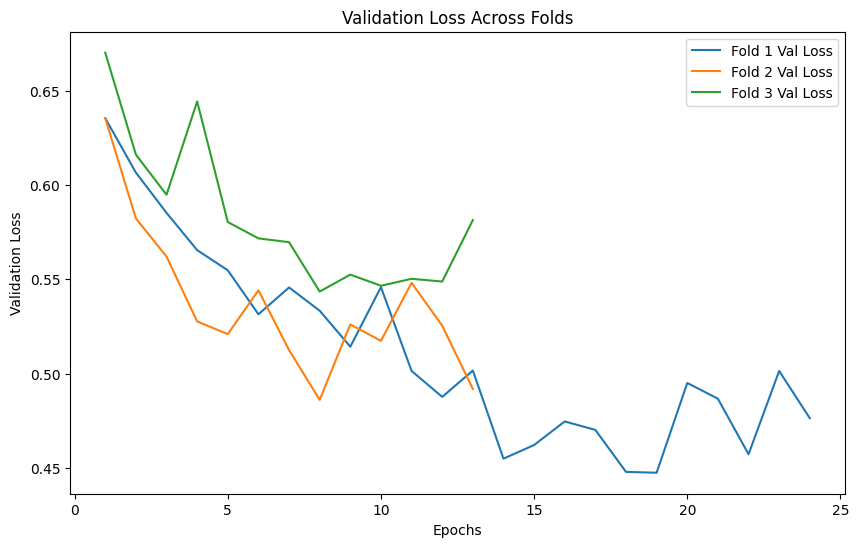

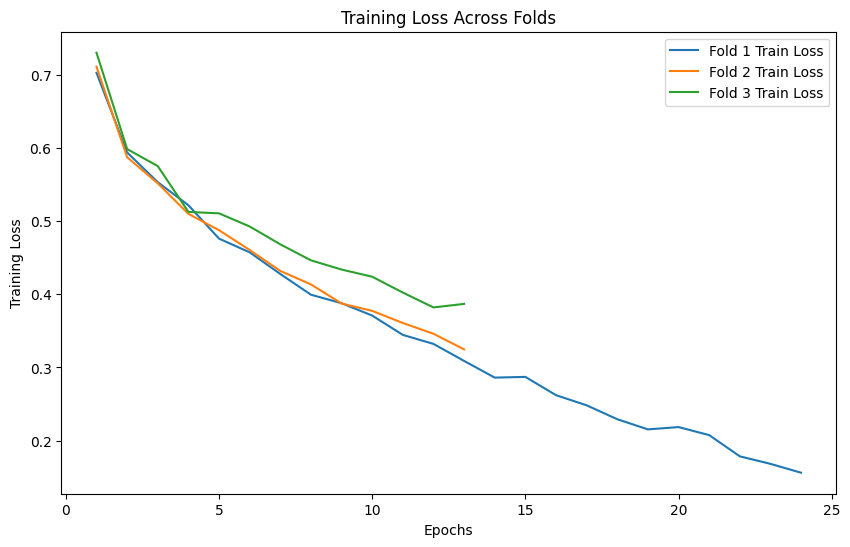

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
from torchvision import datasets, transforms
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 8
learning_rate = 0.00001
num_epochs = 50
k_folds = 3
early_stopping_patience = 5

# Transformations
train_transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Dataset
dataset_path = '/content/drive/MyDrive/dataset_Eff_1/dataset_Eff'
dataset = datasets.ImageFolder(root=dataset_path, transform=train_transform)

# Cross-validation setup
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Initialize metrics for cross-validation
fold_train_loss, fold_val_loss = [], []
fold_train_acc, fold_val_acc = [], []
fold_precision, fold_recall, fold_f1 = [], [], []

# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f"Starting Fold {fold + 1}/{k_folds}")

    # Subset the dataset for this fold
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)

    # DataLoaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Initialize model, loss, and optimizer
    model = ShallowCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    # Track losses and accuracy for this fold
    train_losses, val_losses = [], []
    train_acc, val_acc = [], []
    best_val_loss = float('inf')
    early_stopping_counter = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_acc.append(correct / total)

        # Validation phase
        model.eval()
        running_loss, correct, total = 0.0, 0, 0
        y_true, y_pred = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        val_losses.append(running_loss / len(val_loader))
        val_acc.append(correct / total)

        # Early stopping
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            early_stopping_counter = 0
            torch.save(model.state_dict(), f"best_model_fold_{fold + 1}.pt")
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

    # Store metrics for this fold
    fold_train_loss.append(train_losses)
    fold_val_loss.append(val_losses)
    fold_train_acc.append(train_acc)
    fold_val_acc.append(val_acc)
    fold_precision.append(precision_score(y_true, y_pred, average='weighted'))
    fold_recall.append(recall_score(y_true, y_pred, average='weighted'))
    fold_f1.append(f1_score(y_true, y_pred, average='weighted'))

    print(f"Fold {fold + 1} - Train Loss: {np.mean(train_losses):.4f}, Val Loss: {np.mean(val_losses):.4f}, "
          f"Train Acc: {np.mean(train_acc):.4f}, Val Acc: {np.mean(val_acc):.4f}")
    print(f"Precision: {fold_precision[-1]:.4f}, Recall: {fold_recall[-1]:.4f}, F1 Score: {fold_f1[-1]:.4f}")

# Plot Validation Loss Across Folds
plt.figure(figsize=(10, 6))
for fold in range(k_folds):
    plt.plot(range(1, len(fold_val_loss[fold]) + 1), fold_val_loss[fold], label=f'Fold {fold + 1} Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Across Folds')
plt.legend()
plt.show()

# Plot Training Loss Across Folds
plt.figure(figsize=(10, 6))
for fold in range(k_folds):
    plt.plot(range(1, len(fold_train_loss[fold]) + 1), fold_train_loss[fold], label=f'Fold {fold + 1} Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss Across Folds')
plt.legend()
plt.show()

In [6]:
import os
import numpy as np
import cv2
from PIL import Image, ImageEnhance
import torch
import torchvision.transforms as transforms

# Function to preprocess a single image using methodology2
def do_methodology2(image_path, output_dir='temp_processed/'):
    """
    Preprocess a single image: adjust contrast, sharpen, resize, and normalize.

    Args:
        image_path: Path to the input image.
        output_dir: Temporary directory to save the processed image.

    Returns:
        processed_image_path: Path to the processed image.
    """
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Output path for the processed image
    filename = os.path.basename(image_path)
    output_path = os.path.join(output_dir, filename)

    # Load image using PIL and convert to RGB
    img = Image.open(image_path).convert('RGB')  # Ensure it's in RGB mode

    # Adjust contrast using PIL
    enhancer = ImageEnhance.Contrast(img)
    img = enhancer.enhance(1.5)  # Adjust the factor as needed (1.0 means no change)

    # Convert PIL image to NumPy array and convert from RGB to BGR (for OpenCV processing)
    img_np = np.array(img)
    img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR for OpenCV

    # Sharpening using OpenCV
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])  # Sharpening kernel
    img_np = cv2.filter2D(img_np, -1, kernel)

    # Convert back from BGR to RGB for saving and display with PIL
    img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)

    # Resize image using OpenCV
    resized_image = cv2.resize(img_np, (640, 640), interpolation=cv2.INTER_LINEAR)

    # Normalize using OpenCV
    normalized_image = cv2.normalize(resized_image, None, 0, 255, cv2.NORM_MINMAX)

    # Convert back to PIL and save the final image
    normalized_image_pil = Image.fromarray(normalized_image)
    normalized_image_pil.save(output_path, format='PNG', quality=100)

    return output_path

# Function to apply Test-Time Augmentation (TTA) during inference
def tta_augmentations(image, transform_list):
    augmented_images = [transform(image) for transform in transform_list]
    return torch.stack(augmented_images)

# Function to classify a single preprocessed image using an ensemble of folds with TTA
def classify_image_with_folds_tta(model, processed_image_path, tta_transforms, num_folds, class_names, weight_path_template="best_model_fold_{}.pt"):
    # Load the processed image
    preprocessed_image = Image.open(processed_image_path).convert('RGB')

    # Apply TTA transformations
    augmented_images = tta_augmentations(preprocessed_image, tta_transforms).to(device)

    # Aggregate predictions from all folds
    num_classes = len(class_names)
    fold_predictions = torch.zeros(num_classes).to(device)

    for fold_index in range(1, num_folds + 1):
        model = load_fold_weights(model, fold_index, weight_path_template)

        with torch.no_grad():
            for augmented_image in augmented_images:
                augmented_image = augmented_image.unsqueeze(0)  # Add batch dimension
                outputs = model(augmented_image)
                probabilities = torch.softmax(outputs, dim=1)
                fold_predictions += probabilities.squeeze(0)

    # Average the predictions
    averaged_predictions = fold_predictions / (num_folds * len(tta_transforms))
    final_class_index = torch.argmax(averaged_predictions).item()
    final_class_name = class_names[final_class_index]

    return final_class_name

# Define TTA transformations
tta_transforms = [
    transforms.Compose([
        transforms.Resize((640, 640)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
]

# Define the model architecture
model = ShallowCNN().to(device)

# Define class names (e.g., 'box' and 'non-box')
class_names = ['box', 'non-box']

# Number of folds used in training
num_folds = 3  # Replace with the actual number of folds you used

# Path to the unseen image
image_path = "/content/1 (175).jpg"  # Replace with the actual image path

# Preprocess the image using methodology2
processed_image_path = do_methodology2(image_path)

# Classify the processed image using the ensemble of folds with TTA
predicted_class = classify_image_with_folds_tta(model, processed_image_path, tta_transforms, num_folds, class_names)
print(f"The predicted class based on the ensemble of folds with TTA is: {predicted_class}")

<ipython-input-5-82cd55c4dda2>:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path, map_location=device))


The predicted class based on the ensemble of folds with TTA is: box
